In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import pairplot, set_style
import seaborn as sns

In [2]:
df = pd.read_csv("pharmacy_tx.csv")

In [3]:
df.head()

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay
0,2022-01-02,Pharmacy #6,G99.93,branded tanoclolol,725700,1UQC,NaN,False,13.39
1,2022-01-02,Pharmacy #42,U60.52,branded oxasoted,664344,NaN,52H8KH0F83K,False,7.02
2,2022-01-02,Pharmacy #37,Q85.91,branded cupitelol,725700,1UQC,NaN,False,13.39
3,2022-01-02,Pharmacy #30,U60.52,generic oxasoted,571569,KB38N,6BYJBW,False,10.84
4,2022-01-02,Pharmacy #18,N55.01,branded mamate,664344,NaN,ZX2QUWR,False,47.00


## 1. Rejected claims: payment 0

The box plot below suggest that patient_pay is 0 if the claim is rejected.

<AxesSubplot:xlabel='rejected', ylabel='patient_pay'>

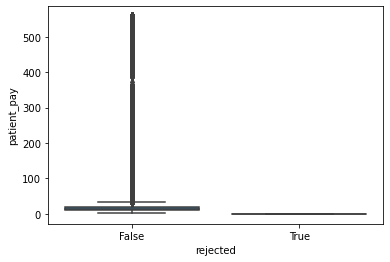

In [4]:
sns.boxplot(x = 'rejected', y = 'patient_pay', data = df)

Indeed, we can check that is true.

In [5]:
print("The minimum value of rejected payment is: %d" %df.loc[df.rejected == True, 'patient_pay'].min())
print("The maximum value of rejected payment is: %d" %df.loc[df.rejected == True, 'patient_pay'].max())

The minimum value of rejected payment is: 0
The maximum value of rejected payment is: 0


Hence for a copayment prediction model, we need to restrict on accepted(not rejected) claims.

## 2. Distribution of copayment

Text(0, 0.5, 'Density')

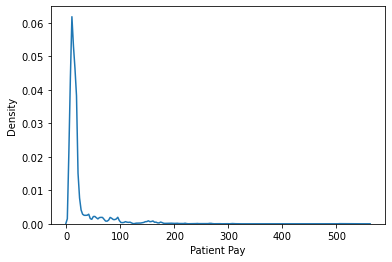

In [6]:
sns.kdeplot(
    x = "patient_pay",
    data = df.loc[df['rejected'] == False]
)

plt.xlabel("Patient Pay")
plt.ylabel("Density")

In [7]:
df_accepted = df.loc[df.rejected == False]

In [14]:
df_accepted = df_accepted.assign(log_patient_pay = np.log(df_accepted['patient_pay']))

Text(0, 0.5, 'Density')

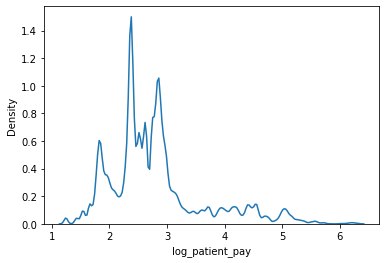

In [15]:
sns.kdeplot(
    x = "log_patient_pay",
    data = df_accepted
)

plt.xlabel("log_patient_pay")
plt.ylabel("Density")

We can observe that most patient paid less than 100 dollars.

In [16]:
df_accepted = df.loc[df['rejected'] == False]

In [17]:
len(df_accepted.loc[df['patient_pay'] <= 100]) / len(df_accepted) * 100

95.48198041952108

Copayments less than 100 dollars account approximately 95.5% of the whole accepted claims

In [ ]:
df_accepted.loc[df_accepted['patient_pay'] > 100]

In [ ]:
df_accepted.diagnosis.value_counts()

In [ ]:
df_accepted.loc[df_accepted['patient_pay'] > 100].diagnosis.value_counts()

In [29]:
df.drug.value_counts()

generic prazinib        865905
branded prazinib        845852
branded mule            543372
branded hidizuzunib     484868
generic rulfalol        360884
                         ...  
branded sizubesin         8130
branded lehydrome         2561
generic gohevitravir      2303
branded gohevitravir      1811
branded nenizevir         1112
Name: drug, Length: 114, dtype: int64

In [51]:
df.loc[df.patient_pay > 100].diagnosis.value_counts()

Z66.42    154383
Z20.23     54363
G51.87     40461
Q72.66     33868
M06.85     24568
           ...  
H11.36         7
P29.44         7
N33.46         7
W00.33         6
H26.61         1
Name: diagnosis, Length: 77, dtype: int64

In [56]:
df.loc[df.patient_pay > 400].diagnosis.nunique()

8

In [54]:
df.diagnosis.nunique()

133

In [30]:
df.loc[df.patient_pay > 100].drug.value_counts()

branded diadaric          95549
branded nusudaric         86224
branded choxestamenium    61140
branded tugesutin         58554
branded nephelilin        41373
branded vivafastat        31551
branded flacelfatastat    29433
branded fazipilin         24593
branded notin             24344
branded monemodiase       20768
branded prefluflomycin    17011
branded debome            13275
branded genetramycicin    11391
branded devacin           10016
branded gosate             9788
branded hidizuzunib        8996
branded plazamiglutic      7988
branded masonic            7941
branded pranic             7698
branded pheromycin         6598
branded cuxirin            4114
branded todiadianic         739
branded gentipapavir        266
branded nenizevir            13
Name: drug, dtype: int64

In [31]:
df.loc[df.patient_pay > 200].drug.value_counts()

branded tugesutin         28800
branded flacelfatastat    25684
branded monemodiase       20768
branded prefluflomycin    14614
branded masonic            6611
branded pheromycin         6598
branded pranic             5694
branded diadaric           1299
branded vivafastat          543
branded genetramycicin      230
Name: drug, dtype: int64

In [32]:
df.loc[df.patient_pay > 500].drug.value_counts()

branded monemodiase    10084
Name: drug, dtype: int64

In [36]:
df.loc[df.drug == 'branded monemodiase'].rejected.value_counts()

False    24446
True     11498
Name: rejected, dtype: int64

## 2. What are 'bin', 'pcn', and 'group'

According to the project description, 

- bin: The broadest identifier of a patient’s insurance plan (banking identification number)
- pcn: An identifier that more narrowly specifies a plan underneath the broader “bin”
- group: Another identifier that more narrowly specifies a plan underneath the broader “bin”

However, we can see that there are 1-1 correspondence between 'pcn' and 'group'

In [26]:
df.bin.value_counts()

664344    3855462
322463    2542376
725700    2100642
691847    1323776
757349     959441
96934      870740
571569     774925
539437     516933
956971     272906
160389     261912
718350     256611
756120     174520
Name: bin, dtype: int64

In [19]:
df.pcn.value_counts()
df.pcn.nunique()

48

In [20]:
df.group.value_counts()
df.group.nunique()

48

We can observe that observations with both `pcn` and `group` are null, their `bin` are all 571569.

In [30]:
df[df['pcn'].isna() & df['group'].isna()].bin.value_counts()

571569    38080
Name: bin, dtype: int64

## 3. Patient payments and time

Patient payments tend to be higher in the early of the year, say in January. For example, for 'generic prazinib', the most common drug in the data, patients paid more at the beginning of the year. This is likely because of the renewal of the deductible.

C:\Users\riene\AppData\Local\Temp\ipykernel_15116\1009464062.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_accepted[df.drug == 'generic prazinib']['patient_pay'].rolling(1000).mean().plot(xlabel="tx_date", ylabel="patient_pay")


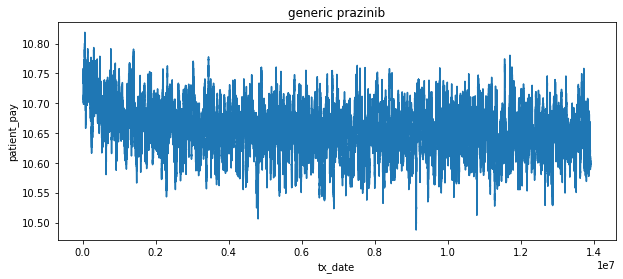

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
df_accepted[df.drug == 'generic prazinib']['patient_pay'].rolling(1000).mean().plot(xlabel="tx_date", ylabel="patient_pay")

plt.title('generic prazinib')
plt.show()

# 4. Drug type: branded/generic

We can observe that branded drugs are likely to be higher patient payments and rejection rates.

In [48]:
df[["drug_type","drug_name"]] =df['drug'].str.split(" ",expand=True)

<AxesSubplot:xlabel='drug_type', ylabel='count'>

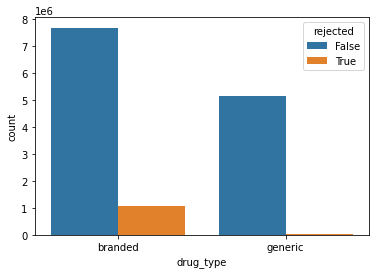

In [50]:
sns.countplot(
    x = "drug_type",
    hue = "rejected",
    data = df
)